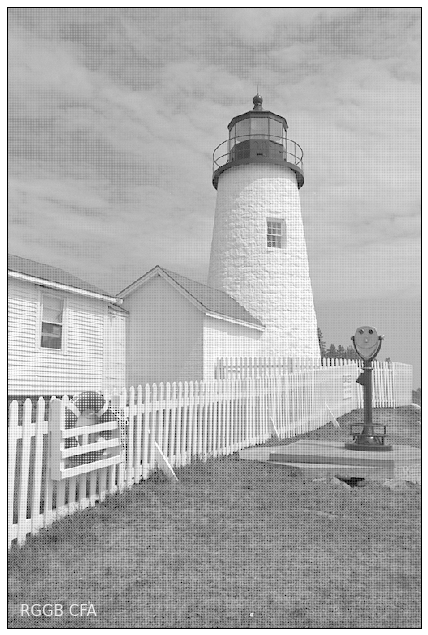

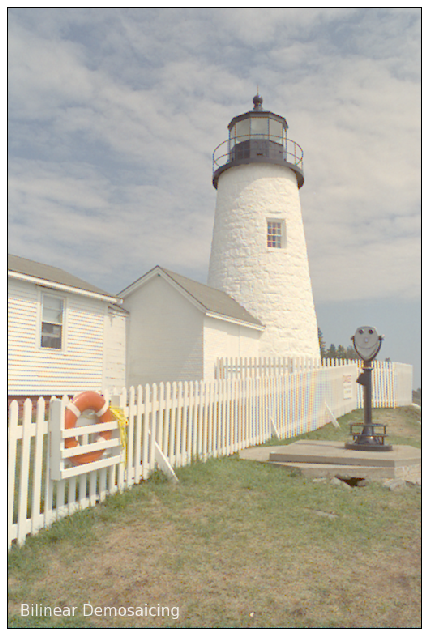

True

In [1]:
%matplotlib inline

from __future__ import division

import numpy as np

import colour
from colour.plotting import *

from colour_hdri.cfa.bayer.demosaicing_bilinear import demosaicing_bilinear_CFA_Bayer
from colour_hdri.cfa.bayer.mosaicing import mosaicing_CFA_Bayer

DIRECTORY = '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/resources/CFA'

OECF = colour.RGB_COLOURSPACES['sRGB'].transfer_function

IMAGE = np.squeeze(colour.read_image(DIRECTORY + '/lighthouse.tif'))

CFA = mosaicing_CFA_Bayer(IMAGE)

image_plot(OECF(colour.tstack((CFA, CFA, CFA))), 'RGGB CFA')
image_plot(OECF(demosaicing_bilinear_CFA_Bayer(CFA)), 'Bilinear Demosaicing')